In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time, datetime
from tqdm.notebook import tqdm

In [2]:
def timeit(f, caption=""):
    now=time.time()
    r=f()
    duration = duration = str(datetime.timedelta(seconds=time.time()-now))
    print(caption+(" - " if(len(caption)>0) else "")+duration)
    return r

In [7]:
years=pd.read_gbq("SELECT DISTINCT(EXTRACT(YEAR from trip_start_timestamp)) FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` ORDER BY 1").values[:,0]
years

array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

# L1 distance correlation with trip_miles, trip_seconds and trip_total

In [60]:
def get_df_corr(year):
    constraint = f"EXTRACT(YEAR from trip_start_timestamp) = {year} and trip_miles>0 and trip_seconds>0 and trip_total>0  and ABS(dropoff_latitude-pickup_latitude) + ABS(dropoff_longitude-pickup_longitude) > 0"
    df_corr = pd.read_gbq(f"""
    WITH 
    measurements AS (
    SELECT unique_key, trip_start_timestamp, trip_miles, trip_seconds, trip_total,dropoff_latitude,pickup_latitude,dropoff_longitude,pickup_longitude,
    ABS(dropoff_latitude-pickup_latitude) + ABS(dropoff_longitude-pickup_longitude) AS L1_distance
    FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`    
    where trip_miles>0 and trip_seconds>0 and trip_total>0  and ABS(dropoff_latitude-pickup_latitude) + ABS(dropoff_longitude-pickup_longitude) > 0
    ),
    numerical_data AS (
    SELECT colname, value, unique_key FROM (
    (SELECT 'trip_miles'           AS colname, trip_miles   AS value, unique_key FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` where {constraint}) UNION ALL
    (SELECT 'L1_distance'          AS colname, L1_distance  AS value, unique_key FROM measurements                                         where {constraint}) UNION ALL
    (SELECT 'trip_seconds'         AS colname, trip_seconds AS value, unique_key FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` where {constraint}) UNION ALL
    (SELECT 'trip_total'           AS colname, trip_total   AS value, unique_key FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` where {constraint})
    )
    )

    SELECT   CORR(a.value, b.value) as corr, 
             a.colname              as col1, 
             b.colname              as col2
    FROM     numerical_data a
    JOIN     numerical_data b
    ON       a.unique_key=b.unique_key
    GROUP BY a.colname, b.colname 
    """)
    return df_corr.pivot("col1", "col2", "corr")

  0%|          | 0/9 [00:00<?, ?it/s]

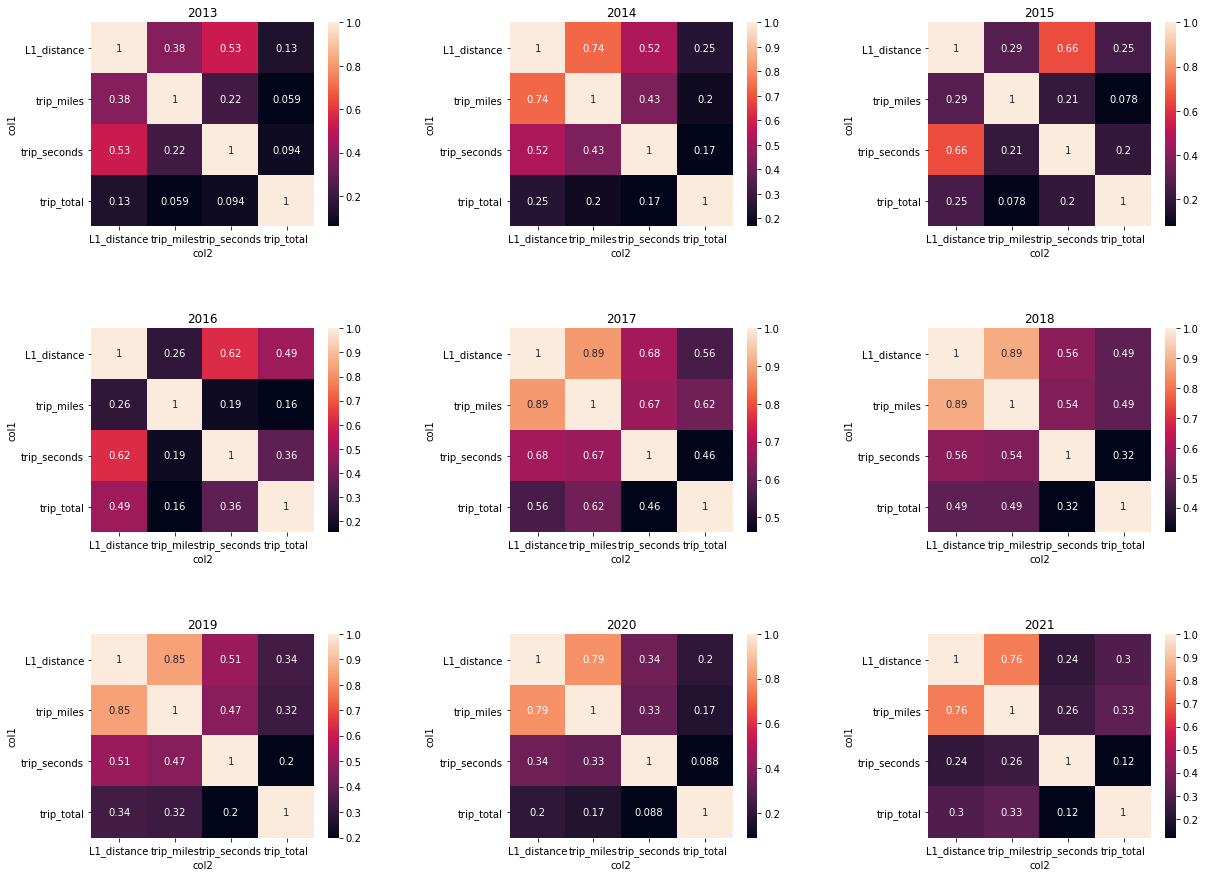

In [61]:
rows = 3
cols = 3
pad  = 0.5
plt.figure(figsize=(20,15))
for i,year in enumerate(tqdm(years)):
    df_corr_mat = get_df_corr(year)
    plt.subplot(rows, cols, i+1)
    ax = sns.heatmap(df_corr_mat, annot=True)
    ax.set_title(f"{year}")
plt.subplots_adjust(wspace=pad, hspace=pad)

# Considerations
* 2017 seems the most promising starting point

---

---

---

# Adding trip_miles, trip_seconds and trip_total on a logarithmic scale

In [66]:
def get_df_corr(year):
    constraint = f"EXTRACT(YEAR from trip_start_timestamp) = {year} and trip_miles>0 and trip_seconds>0 and trip_total>0  and ABS(dropoff_latitude-pickup_latitude) + ABS(dropoff_longitude-pickup_longitude) > 0"
    df_corr = pd.read_gbq(f"""
    WITH 
    measurements AS (
    SELECT unique_key, trip_start_timestamp, trip_miles, trip_seconds, trip_total,dropoff_latitude,pickup_latitude,dropoff_longitude,pickup_longitude,
    ABS(dropoff_latitude-pickup_latitude) + ABS(dropoff_longitude-pickup_longitude) AS L1_distance,
    LOG10(trip_miles) as trip_miles_log,
    LOG10(trip_seconds) as trip_seconds_log,
    LOG10(trip_total) as trip_total_log,
    FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`   
    where trip_miles>0 and trip_seconds>0 and trip_total>0 and ABS(dropoff_latitude-pickup_latitude) + ABS(dropoff_longitude-pickup_longitude) > 0
    ),
    numerical_data AS (
    SELECT colname, value, unique_key FROM (
    (SELECT 'trip_miles'           AS colname, trip_miles       AS value, unique_key FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` where {constraint}) UNION ALL
    (SELECT 'L1_distance'          AS colname, L1_distance      AS value, unique_key FROM measurements                                         where {constraint}) UNION ALL
    (SELECT 'trip_seconds'         AS colname, trip_seconds     AS value, unique_key FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` where {constraint}) UNION ALL
    (SELECT 'trip_total'           AS colname, trip_total       AS value, unique_key FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` where {constraint}) UNION ALL
    
    (SELECT 'trip_miles_log'       AS colname, trip_miles_log   AS value, unique_key FROM measurements                                         where {constraint}) UNION ALL
    (SELECT 'trip_seconds_log'     AS colname, trip_seconds_log AS value, unique_key FROM measurements                                         where {constraint}) UNION ALL
    (SELECT 'trip_total_log'       AS colname, trip_total_log   AS value, unique_key FROM measurements                                         where {constraint})
    )
    )

    SELECT   CORR(a.value, b.value) as corr, 
             a.colname              as col1, 
             b.colname              as col2
    FROM     numerical_data a
    JOIN     numerical_data b
    ON       a.unique_key=b.unique_key
    GROUP BY a.colname, b.colname 
    """)
    return df_corr.pivot("col1", "col2", "corr")

  0%|          | 0/9 [00:00<?, ?it/s]

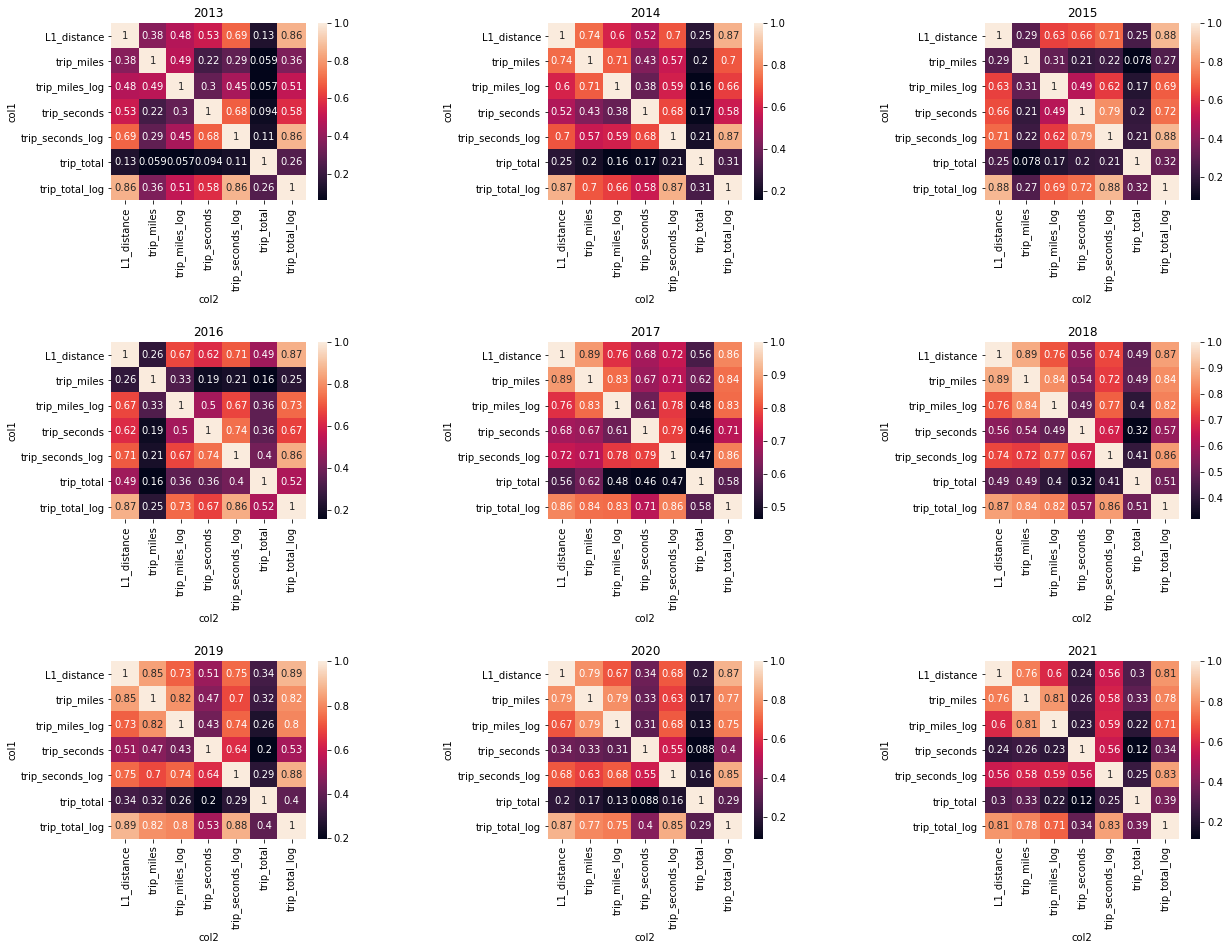

In [67]:
rows = 3
cols = 3
pad  = 0.8
plt.figure(figsize=(20,15))
for i,year in enumerate(tqdm(years)):
    df_corr_mat = get_df_corr(year)
    plt.subplot(rows, cols, i+1)
    ax = sns.heatmap(df_corr_mat, annot=True)
    ax.set_title(f"{year}")
plt.subplots_adjust(wspace=pad, hspace=pad)

# Considerations:
* correlation with L1 distance seems to increase if we use a logarithmic transformation, especially for trip_total

---

---

---

# Other tryouts..

In [62]:
def get_df_corr(year):
    constraint = f"EXTRACT(YEAR from trip_start_timestamp) = {year} and trip_miles>0 and trip_seconds>0 and trip_total>0  and ABS(dropoff_latitude-pickup_latitude) + ABS(dropoff_longitude-pickup_longitude) > 0"
    df_corr = pd.read_gbq(f"""
    WITH 
    measurements AS (
    SELECT unique_key, trip_start_timestamp, trip_miles, trip_seconds, trip_total,dropoff_latitude,pickup_latitude,dropoff_longitude,pickup_longitude,
    ABS(dropoff_latitude-pickup_latitude) + ABS(dropoff_longitude-pickup_longitude) AS L1_distance,
    LOG10(trip_miles) as trip_miles_log,
    LOG10(trip_seconds) as trip_seconds_log,
    LOG10(trip_total) as trip_total_log,
    POW(10, ABS(dropoff_latitude-pickup_latitude) + ABS(dropoff_longitude-pickup_longitude)) as L1_distance_exp,
    LOG10(ABS(dropoff_latitude-pickup_latitude) + ABS(dropoff_longitude-pickup_longitude)) as L1_distance_log
    FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`   
    where trip_miles>0 and trip_seconds>0 and trip_total>0 and ABS(dropoff_latitude-pickup_latitude) + ABS(dropoff_longitude-pickup_longitude) > 0
    ),
    numerical_data AS (
    SELECT colname, value, unique_key FROM (
    (SELECT 'trip_miles'           AS colname, trip_miles       AS value, unique_key FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` where {constraint}) UNION ALL
    (SELECT 'L1_distance'          AS colname, L1_distance      AS value, unique_key FROM measurements                                         where {constraint}) UNION ALL
    (SELECT 'trip_seconds'         AS colname, trip_seconds     AS value, unique_key FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` where {constraint}) UNION ALL
    (SELECT 'trip_total'           AS colname, trip_total       AS value, unique_key FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` where {constraint}) UNION ALL
    
    (SELECT 'trip_miles_log'       AS colname, trip_miles_log   AS value, unique_key FROM measurements                                         where {constraint}) UNION ALL
    (SELECT 'trip_seconds_log'     AS colname, trip_seconds_log AS value, unique_key FROM measurements                                         where {constraint}) UNION ALL
    (SELECT 'trip_total_log'       AS colname, trip_total_log   AS value, unique_key FROM measurements                                         where {constraint}) UNION ALL
    (SELECT 'L1_distance_exp'      AS colname, L1_distance_exp  AS value, unique_key FROM measurements                                         where {constraint}) UNION ALL
    (SELECT 'L1_distance_log'      AS colname, L1_distance_log  AS value, unique_key FROM measurements                                         where {constraint}) 
    )
    )

    SELECT   CORR(a.value, b.value) as corr, 
             a.colname              as col1, 
             b.colname              as col2
    FROM     numerical_data a
    JOIN     numerical_data b
    ON       a.unique_key=b.unique_key
    GROUP BY a.colname, b.colname 
    """)
    return df_corr.pivot("col1", "col2", "corr")

  0%|          | 0/9 [00:00<?, ?it/s]

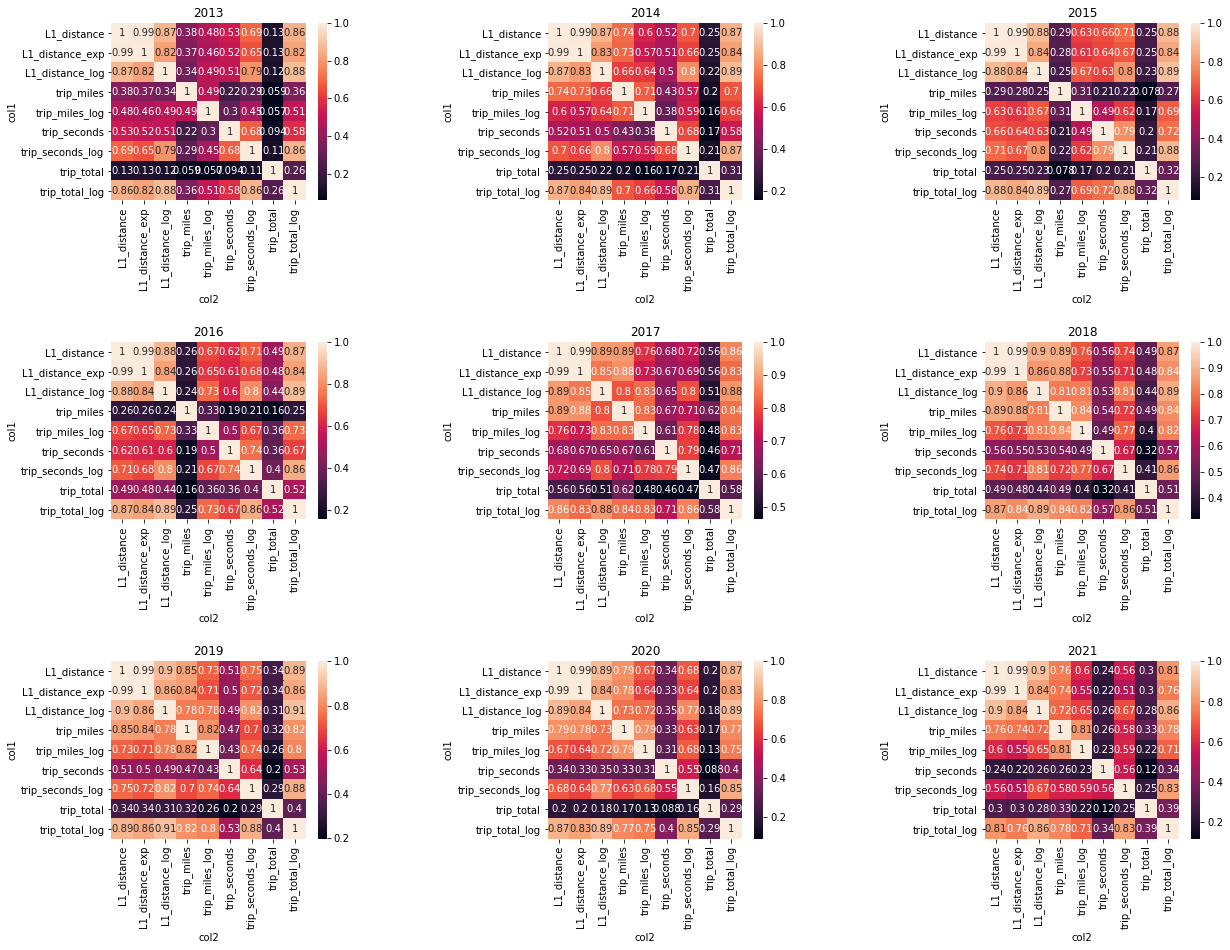

In [63]:
rows = 3
cols = 3
pad  = 0.8
plt.figure(figsize=(20,15))
for i,year in enumerate(tqdm(years)):
    df_corr_mat = get_df_corr(year)
    plt.subplot(rows, cols, i+1)
    ax = sns.heatmap(df_corr_mat, annot=True)
    ax.set_title(f"{year}")
plt.subplots_adjust(wspace=pad, hspace=pad)

# Considerations:
* Added features didn't show improvements